In [47]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seastar
# from cycler import cycler


In [48]:
noise_RSV_sqt = 0.07
noise_RSV_broad = 0.2

In [49]:
wspd_target = [5, 9, 15]
cvel_target = [0, 0.2, 0.6, 1.5]
# azi_target = [0, 90]
pol_target = [1]
inci_broad_target = [20, 28.4, 33.4]
inci_sqt_target = [31.5, 36.5, 40.0]
sqt_ground = [52.2, 45.0, 37.8]
across_distance = [0, 90, 150]

In [50]:
# azi_lw = [2, .5]
# azi_ls = ['-', '--']
# azi_str = ['upwind', 'crosswind']
# pol_ls = ['-', '--']
# pol_lw = [2, .5]
# pol_str = ['VV', 'HH']
# wspd_lw = [.5, 1, 2]

In [51]:
# sigma0_lim = [10**-3.2, 10**0.5]
# inci_lim = [15, 45] # available data [16,65]
wspd_lim = [1, 20]

# Sensitivity to Current Direction

In [52]:
azi_step =  5

cvel = np.array( cvel_target )
# pol   =  np.array([1])
# wspd  =  np.array( wspd_target )
theta_broad =  np.array( inci_broad_target )
theta_sqt =  np.array( inci_sqt_target )
azi   =  np.arange(0, 360, azi_step)

[cvel_mat, theta_broad_mat, azi_mat] =  np.meshgrid(cvel, theta_broad, azi, indexing='ij')
[cvel_mat, theta_sqt_mat, azi_mat] =  np.meshgrid(cvel, theta_sqt, azi, indexing='ij')

[rsc_broad, trash] = seastar.gmfs.doppler.compute_radial_current(
    cvel_mat,
    azi_mat,
    theta_broad_mat
)

[rsc_sqt, trash] = seastar.gmfs.doppler.compute_radial_current(
    cvel_mat,
    azi_mat,
    theta_sqt_mat
)

In [53]:
ds = xr.Dataset(
    data_vars=dict(
        rsc=(['cvel','cell','azi','antenna'], np.stack([rsc_broad, rsc_sqt], axis=-1))
    ),
    coords=dict(
        cell = ['near', 'mid', 'far'],
        inci_broad = (('cell'), inci_broad_target),
        inci_sqt = (('cell'), inci_sqt_target),
        antenna = ['broad', 'sqt'],
        cvel=cvel,
        azi=azi,
        sqt_ground = (('cell'), sqt_ground),
        across_distance =  (('cell'), across_distance),
    )
)
ds.rsc.attrs['long_name'] = 'Radial Surface Current'
ds.rsc.attrs['units'] = 'm/s'
ds.inci_broad.attrs['long_name'] = 'Incidence Angle'
ds.inci_broad.attrs['units'] = '°'
ds.inci_sqt.attrs['long_name'] = 'Incidence Angle'
ds.inci_sqt.attrs['units'] = '°'
ds.azi.attrs['long_name'] = 'Relative Azimuth Angle'
ds.azi.attrs['units'] = '°'

In [54]:
ds

<xarray.Dataset>
Dimensions:          (cvel: 4, cell: 3, azi: 72, antenna: 2)
Coordinates:
  * cell             (cell) <U4 'near' 'mid' 'far'
    inci_broad       (cell) float64 20.0 28.4 33.4
    inci_sqt         (cell) float64 31.5 36.5 40.0
  * antenna          (antenna) <U5 'broad' 'sqt'
  * cvel             (cvel) float64 0.0 0.2 0.6 1.5
  * azi              (azi) int32 0 5 10 15 20 25 30 ... 330 335 340 345 350 355
    sqt_ground       (cell) float64 52.2 45.0 37.8
    across_distance  (cell) int32 0 90 150
Data variables:
    rsc              (cvel, cell, azi, antenna) float64 0.0 0.0 ... 1.494 1.494

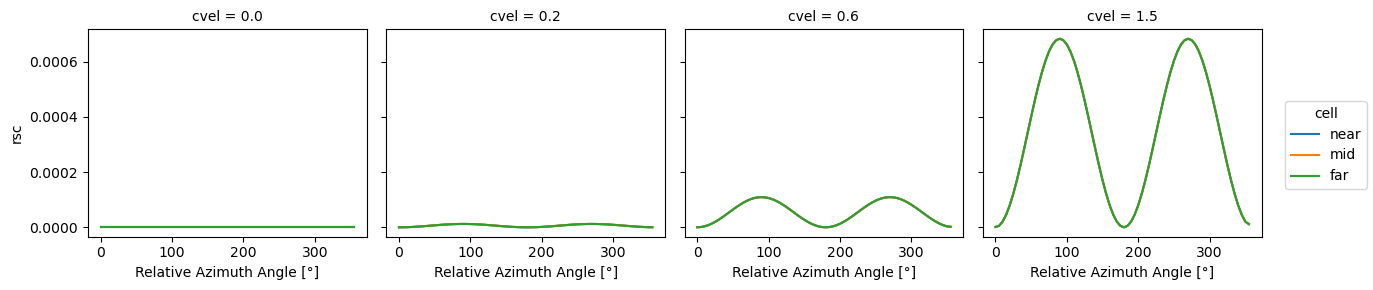

In [55]:
(ds.rsc.differentiate('azi')**2).sel(antenna='broad').plot(x='azi',col='cvel',hue='cell')

In [56]:
ds['drsc_dazi_2'] = ds.rsc.differentiate('azi')**2
# ds['mean_WASV'] = ds.WASV.mean(dim='azi')

In [57]:
# ds['shift_fore'] = np.round((90-ds.sqt_ground)/azi_step)
# ds['shift_aft'] = np.round((90+ds.sqt_ground)/azi_step)
# ds['shift_fore'] = np.round(45/azi_step)
# ds['shift_broad'] = np.round(90/azi_step)
# ds['shift_aft'] = np.round(135/azi_step)
shift_fore  = int(np.round(45/azi_step))
shift_broad = int(np.round(90/azi_step))
shift_aft   = int(np.round(135/azi_step))

ds['norm_drscdazi_2_fore'] = ds.drsc_dazi_2.roll(azi=shift_fore).sel(antenna='sqt') / noise_RSV_sqt**2
ds['norm_drscdazi_2_broad'] = ds.drsc_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / noise_RSV_broad**2
ds['norm_drscdazi_2_aft'] = ds.drsc_dazi_2.roll(azi=shift_aft).sel(antenna='sqt')  / noise_RSV_sqt**2
ds['norm_drscdazi_2_tot_sqt'] = ds['norm_drscdazi_2_fore'] + ds['norm_drscdazi_2_aft']
ds['norm_drscdazi_2_tot'] = ds['norm_drscdazi_2_tot_sqt'] + ds['norm_drscdazi_2_broad']

In [58]:
# Test for the normalisation with Sigma0 at the given azimuth instead of the mean sigma0 over all azimuth 
# => Does not affect dramaticaly the results, same behaviour even if changes at the peak of sensitivity (not strong at Near + low WSpd)
# ds['norm_ds0lindazi_2b_broad'] = ds.ds0lin_dazi_2.roll(azi=shift_broad).sel(antenna='broad')  / (Kp_broad * ds.sigma0_lin.sel(antenna='broad') )**2

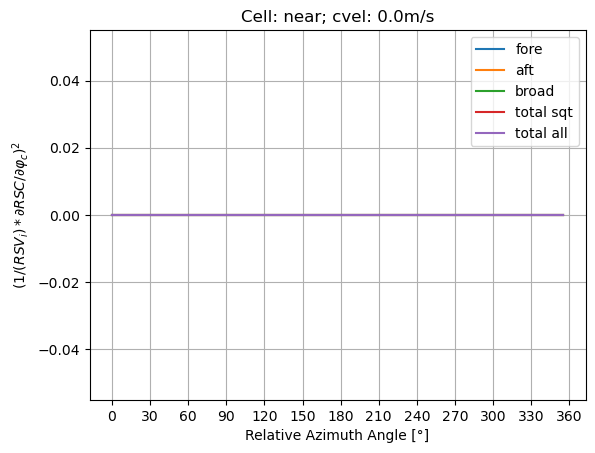

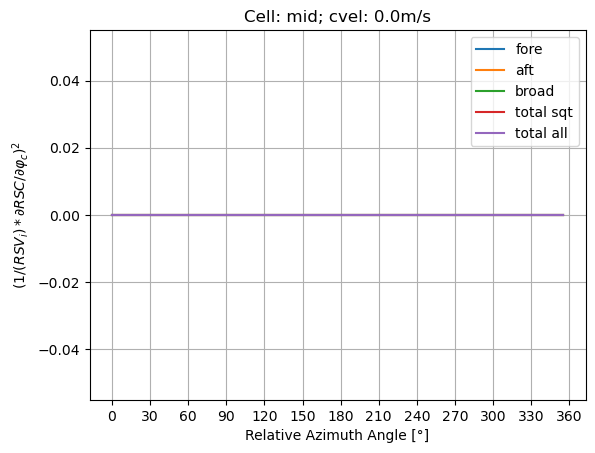

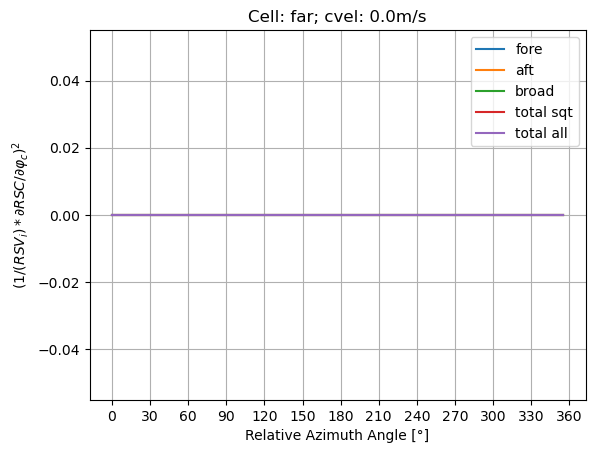

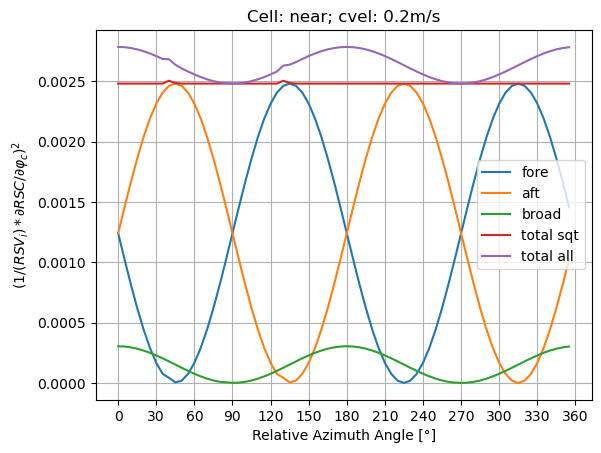

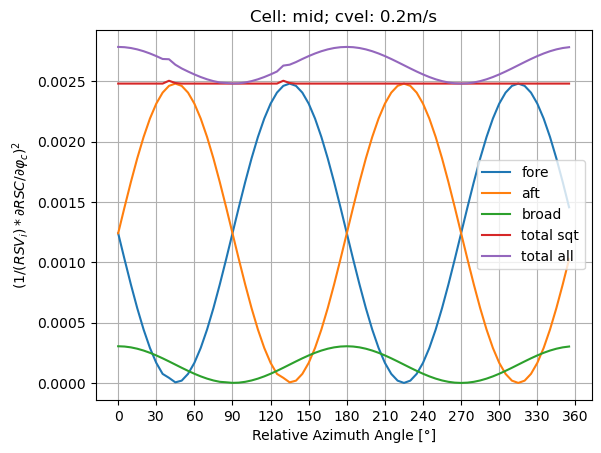

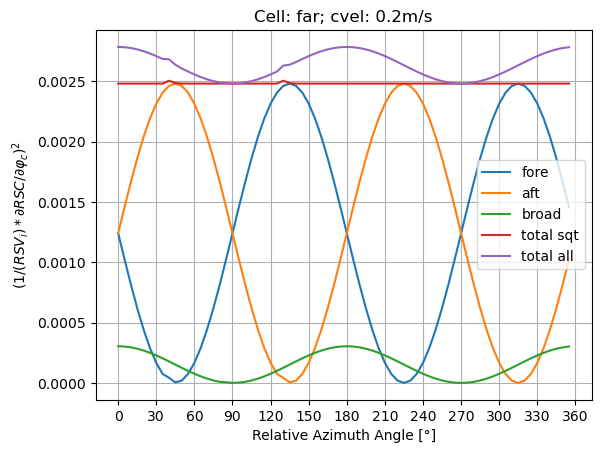

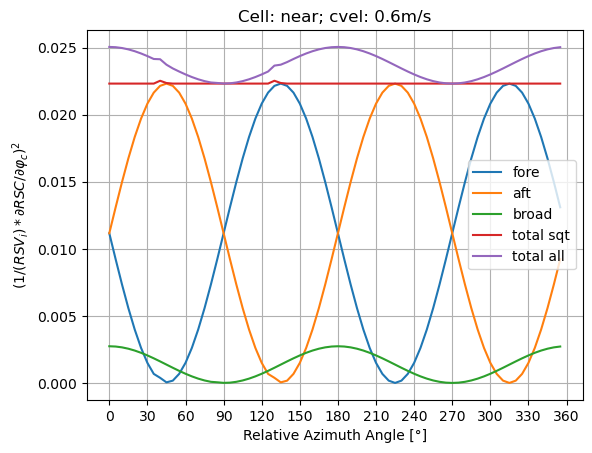

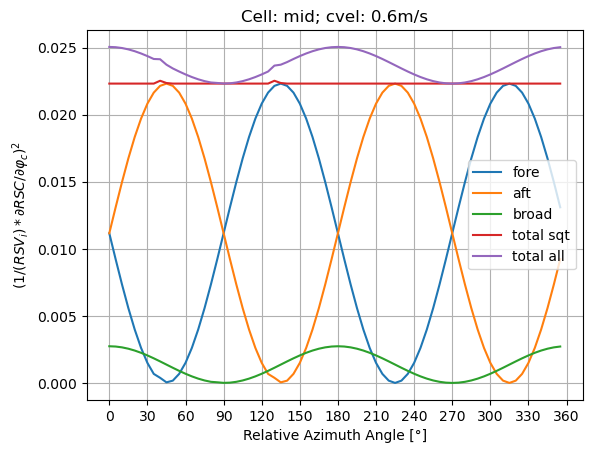

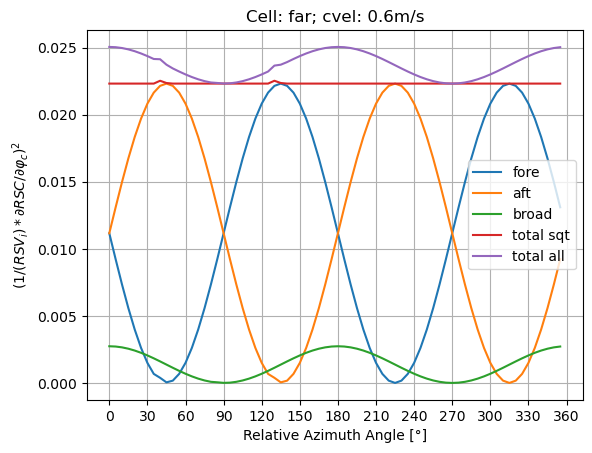

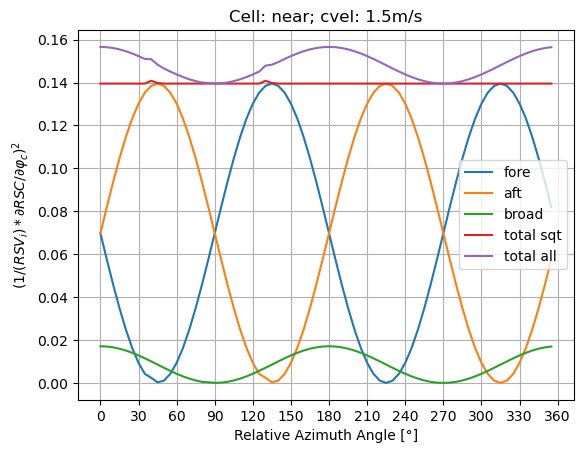

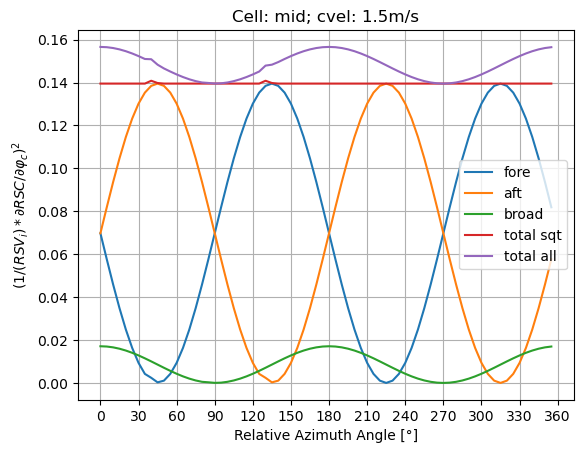

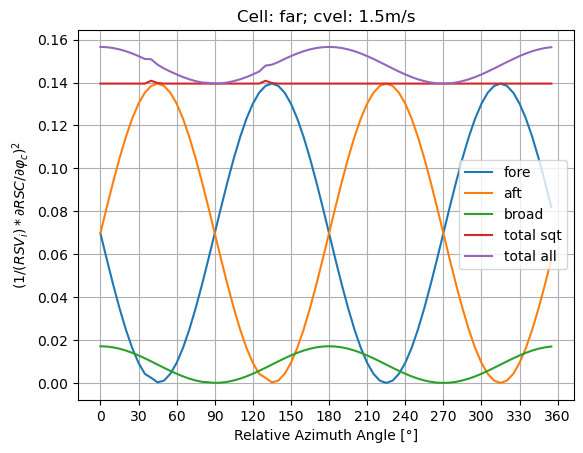

In [59]:
for cvel in cvel_target:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_drscdazi_2_fore\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_drscdazi_2_aft\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_drscdazi_2_broad\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='broad',
                )
#         ds.norm_drscdazi_2b_broad\
#             .sel(cell=cell)\
#             .sel(cvel=cvel)\
#             .plot(
#                 ax=ax,
#                 label='b_broad',
#                 )
        ds.norm_drscdazi_2_tot_sqt\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_drscdazi_2_tot\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='total all',
                )
        plt.xticks(np.arange(0,361,30))
        plt.grid()
        plt.title(f'Cell: {cell}; cvel: {cvel:01.1f}m/s')
        plt.legend()
        plt.ylabel(r'$\left(1/(RSV_i) * \partial{RSC}/\partial{\varphi_c}\right)^2$')

# Sensitivity to Current Velocity

In [60]:
azi_step =  45
cvel_step = 0.1

# pol   =  np.array([1])
cvel  =  np.arange(0, 2, cvel_step)
theta_broad =  np.array( inci_broad_target )
theta_sqt =  np.array( inci_sqt_target )
azi   =  np.arange(0, 360, azi_step)

[cvel_mat, theta_broad_mat, azi_mat] =  np.meshgrid(cvel, theta_broad, azi, indexing='ij')
[cvel_mat, theta_sqt_mat, azi_mat] =  np.meshgrid(cvel, theta_sqt, azi, indexing='ij')

[rsc_broad, trash] = seastar.gmfs.doppler.compute_radial_current(
    cvel_mat,
    azi_mat,
    theta_broad_mat
)

[rsc_sqt, trash] = seastar.gmfs.doppler.compute_radial_current(
    cvel_mat,
    azi_mat,
    theta_sqt_mat
)

In [61]:
ds = xr.Dataset(
    data_vars=dict(
        rsc=(['cvel','cell','azi','antenna'], np.stack([rsc_broad, rsc_sqt], axis=-1))
    ),
    coords=dict(
        cell = ['near', 'mid', 'far'],
        inci_broad = (('cell'), inci_broad_target),
        inci_sqt = (('cell'), inci_sqt_target),
        antenna = ['broad', 'sqt'],
        cvel=cvel,
        azi=azi,
        sqt_ground = (('cell'), sqt_ground),
        across_distance =  (('cell'), across_distance),
    )
)
ds.rsc.attrs['long_name'] = 'Radial Surface Current'
ds.rsc.attrs['units'] = 'm/s'
ds.inci_broad.attrs['long_name'] = 'Incidence Angle'
ds.inci_broad.attrs['units'] = '°'
ds.inci_sqt.attrs['long_name'] = 'Incidence Angle'
ds.inci_sqt.attrs['units'] = '°'
ds.azi.attrs['long_name'] = 'Relative Azimuth Angle'
ds.azi.attrs['units'] = '°'

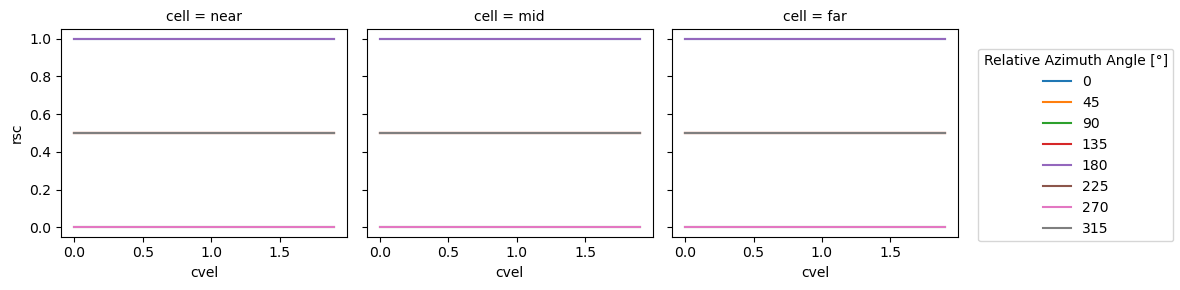

In [62]:
(ds.rsc.differentiate('cvel')**2).sel(antenna='broad').plot(x='cvel',col='cell',hue='azi')

In [63]:
ds['drsc_dcvel_2'] = ds.rsc.differentiate('cvel')**2
# ds['mean_WASV'] = ds.sigma0_lin.mean(dim='azi')

In [64]:
# ds['shift_fore'] = np.round((90-ds.sqt_ground)/azi_step)
# ds['shift_aft'] = np.round((90+ds.sqt_ground)/azi_step)
# ds['shift_fore'] = np.round(45/azi_step)
# ds['shift_broad'] = np.round(90/azi_step)
# ds['shift_aft'] = np.round(135/azi_step)
shift_fore  = int(np.round(45/azi_step))
shift_broad = int(np.round(90/azi_step))
shift_aft   = int(np.round(135/azi_step))

ds['norm_drscdcvel_2_fore'] = ds.drsc_dcvel_2.roll(azi=shift_fore).sel(antenna='sqt') / noise_RSV_sqt**2
ds['norm_drscdcvel_2_broad'] = ds.drsc_dcvel_2.roll(azi=shift_broad).sel(antenna='broad')  / noise_RSV_broad**2
ds['norm_drscdcvel_2_aft'] = ds.drsc_dcvel_2.roll(azi=shift_aft).sel(antenna='sqt')  / noise_RSV_sqt**2
ds['norm_drscdcvel_2_tot_sqt'] = ds['norm_drscdcvel_2_fore'] + ds['norm_drscdcvel_2_aft']
ds['norm_drscdcvel_2_tot'] = ds['norm_drscdcvel_2_tot_sqt'] + ds['norm_drscdcvel_2_broad']

C:\Users\adrien-NOV\AppData\Local\Temp\ipykernel_21872\2277994696.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


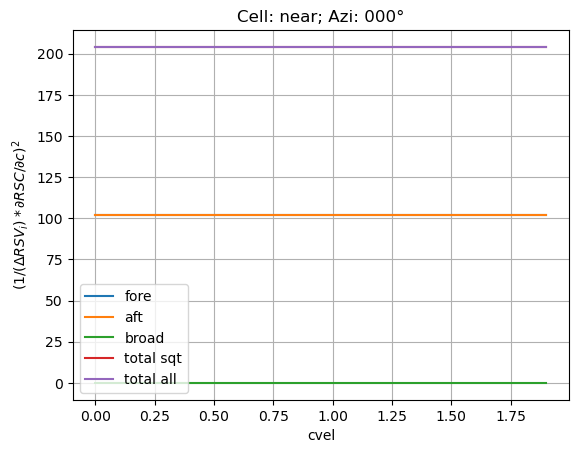

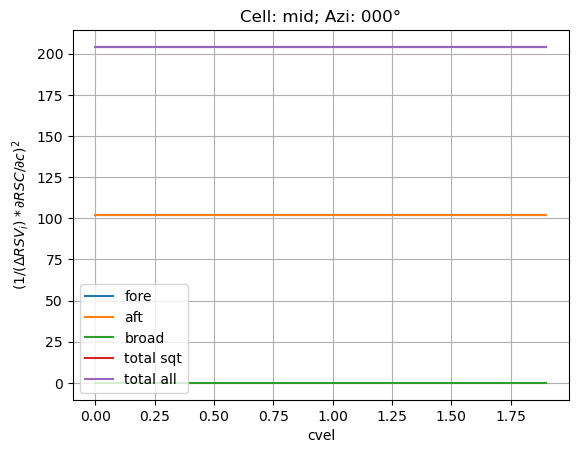

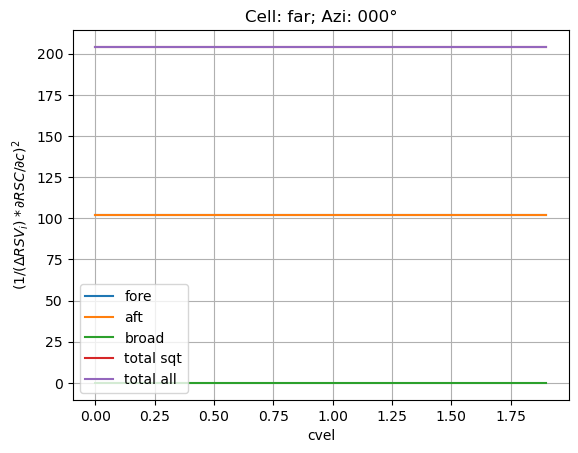

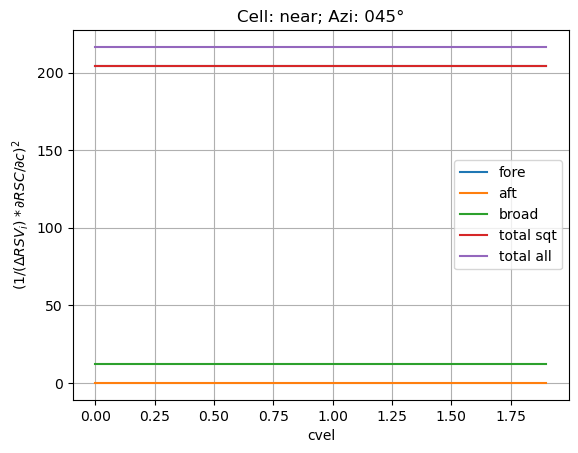

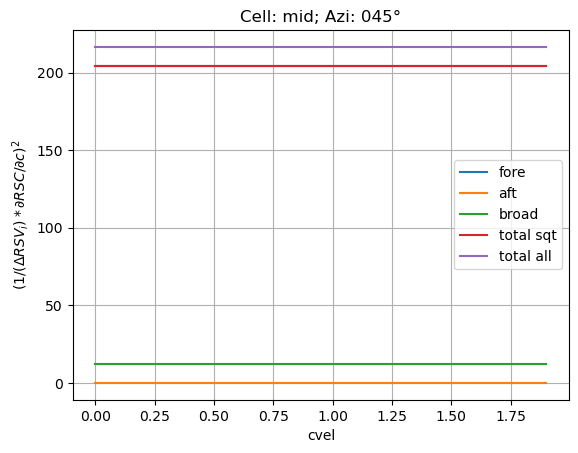

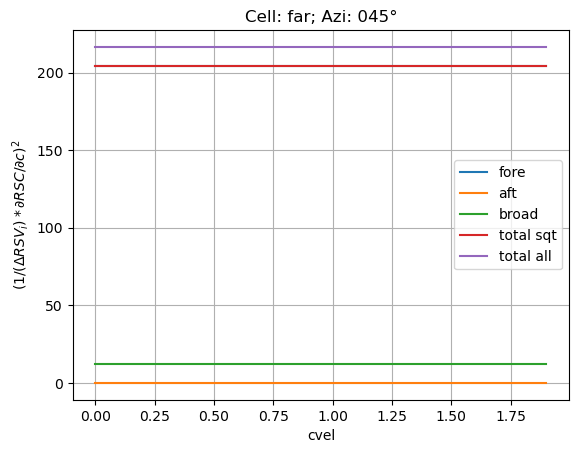

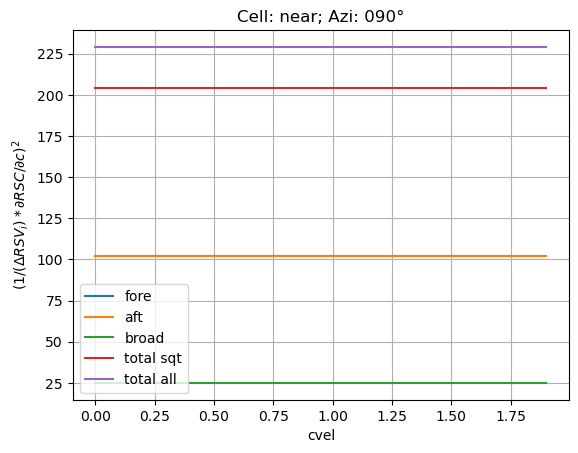

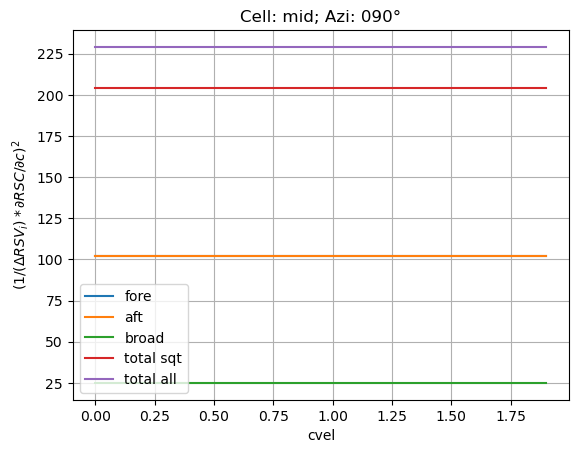

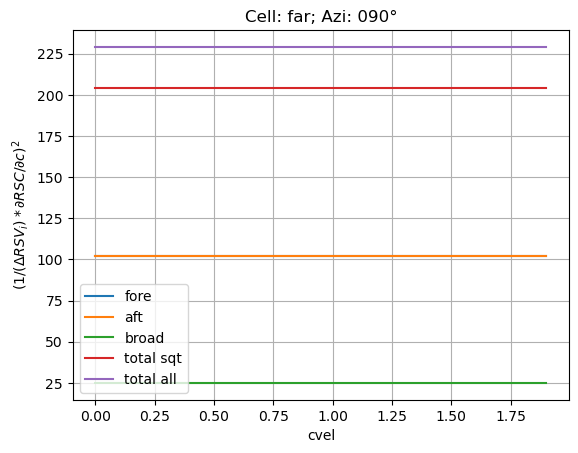

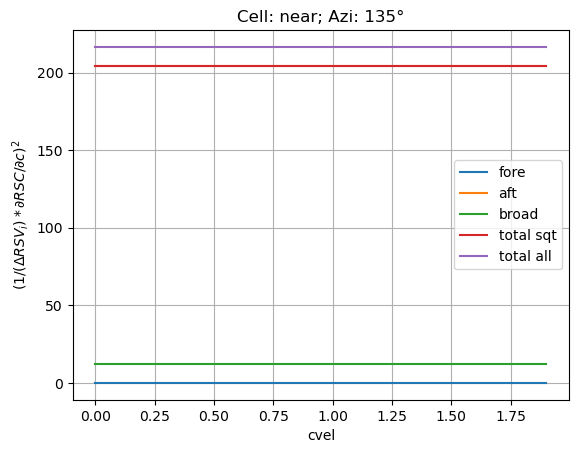

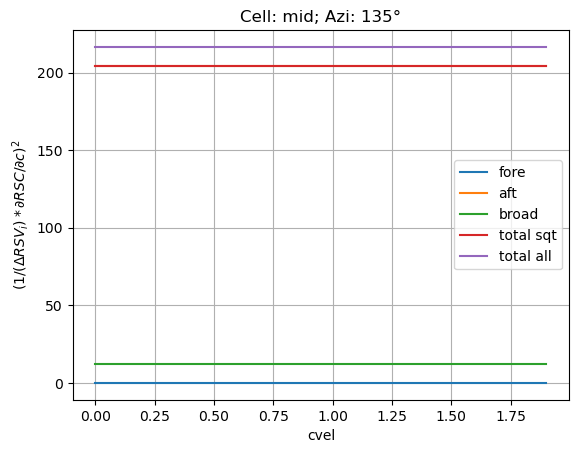

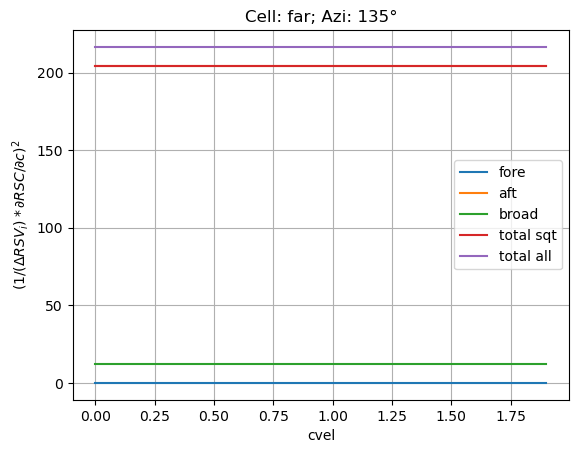

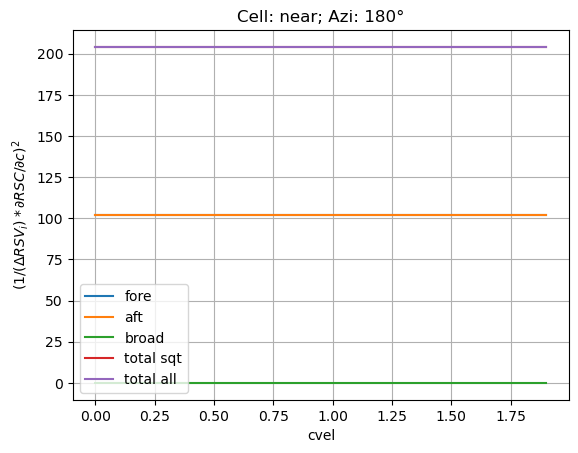

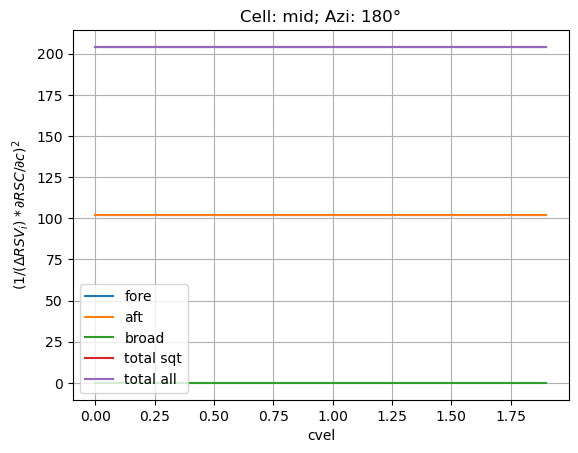

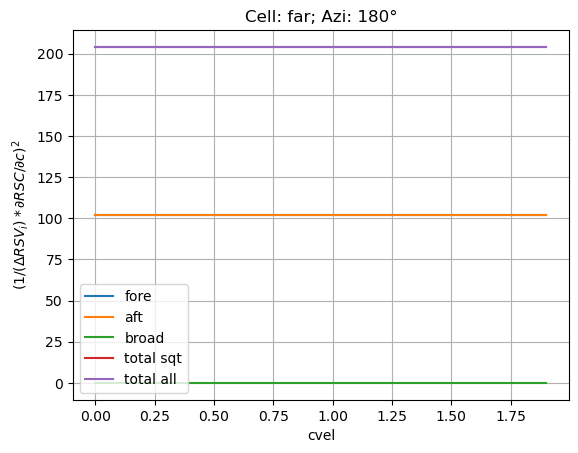

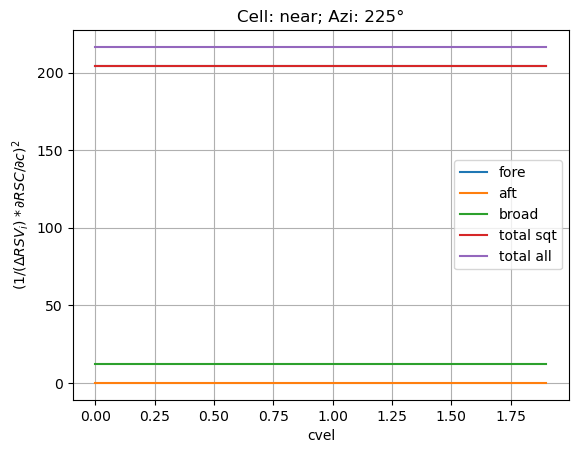

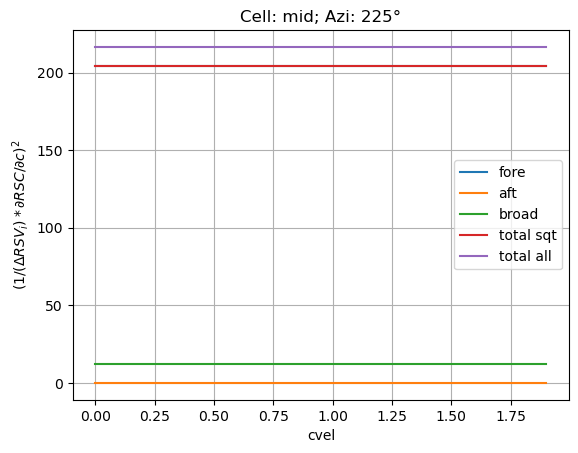

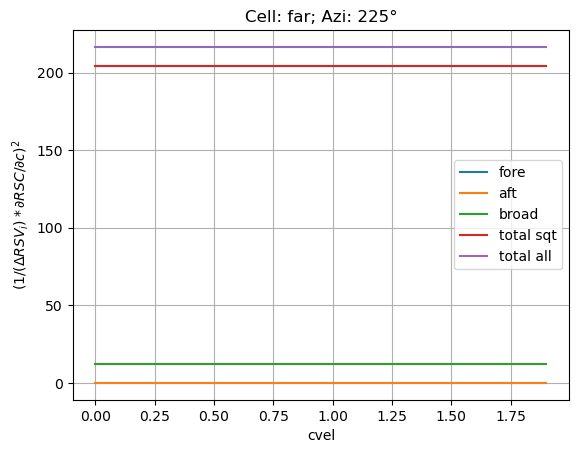

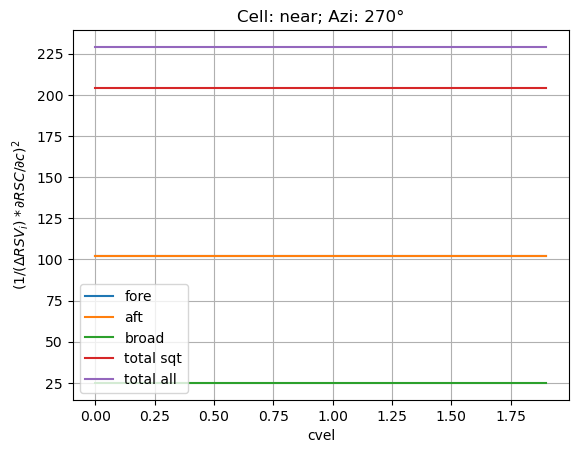

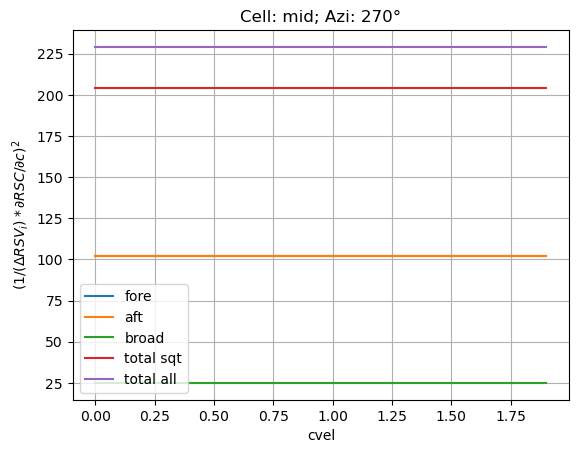

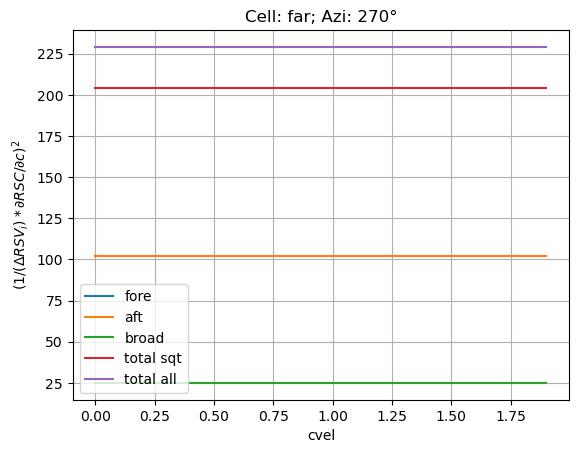

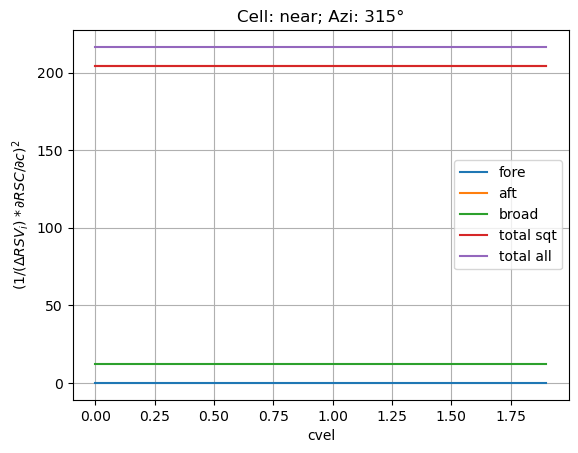

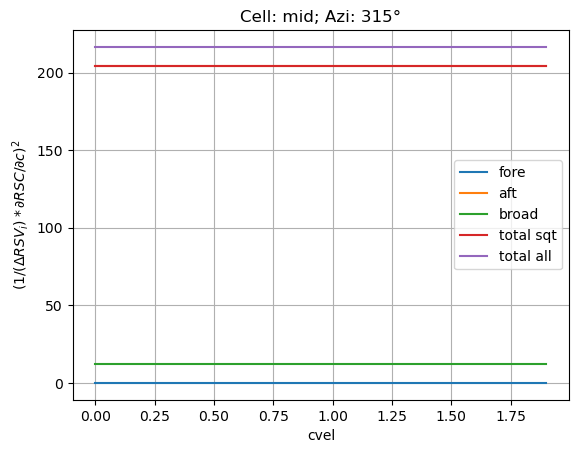

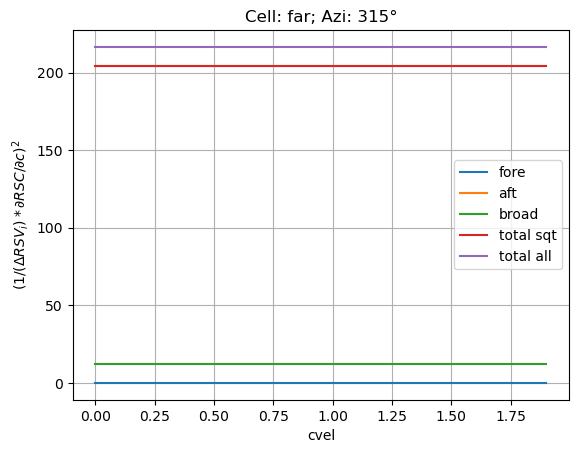

In [65]:
for azi in ds.azi.values:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_drscdcvel_2_fore\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_drscdcvel_2_aft\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_drscdcvel_2_broad\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='broad',
                )
#         ds.norm_drscdcvel_2b_broad\
#             .sel(cell=cell)\
#             .sel(azi=azi)\
#             .plot(
#                 ax=ax,
#                 label='b_broad',
#                 )
        ds.norm_drscdcvel_2_tot_sqt\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_drscdcvel_2_tot\
            .sel(cell=cell)\
            .sel(azi=azi)\
            .plot(
                ax=ax,
                label='total all',
                )
#         plt.xlim([4, 20])
#         plt.ylim([0,2000])
#         plt.xticks(np.arange(4,361,30))
        plt.grid()
        plt.title(f'Cell: {cell}; Azi: {azi:03.0f}°')
        plt.legend()
        plt.ylabel(r'$\left(1/(\Delta RSV_i) * \partial{RSC}/\partial{c}\right)^2$')

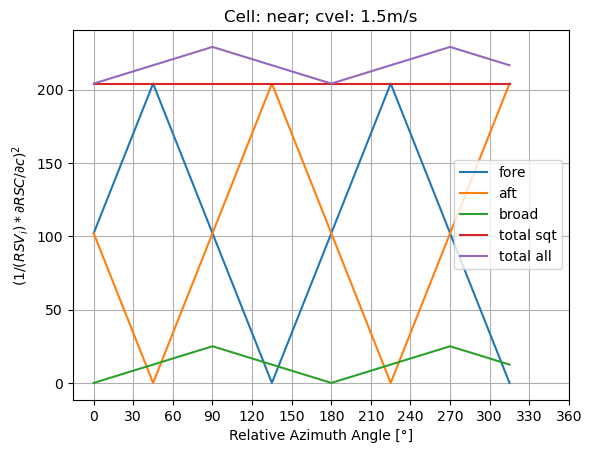

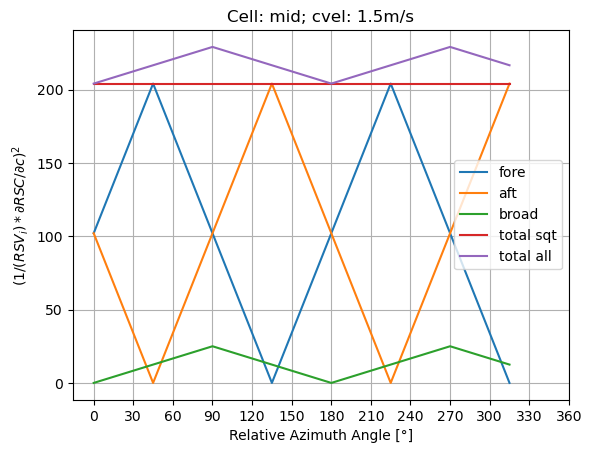

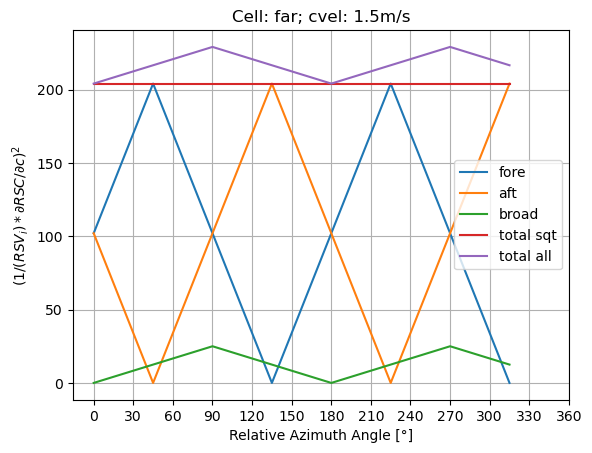

In [66]:
for cvel in [cvel_target[-1]]:
    for cell in ds.cell.values:
        fig = plt.figure()
        ax = plt.gca()
        ds.norm_drscdcvel_2_fore\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='fore',
                )
        ds.norm_drscdcvel_2_aft\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='aft',
                )
        ds.norm_drscdcvel_2_broad\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='broad',
                )
#         ds.norm_drscdcvel_2b_broad\
#             .sel(cell=cell)\
#             .sel(cvel=cvel)\
#             .plot(
#                 ax=ax,
#                 label='b_broad',
#                 )
        ds.norm_drscdcvel_2_tot_sqt\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='total sqt',
                )
        ds.norm_drscdcvel_2_tot\
            .sel(cell=cell)\
            .sel(cvel=cvel)\
            .plot(
                ax=ax,
                label='total all',
                )
        plt.xticks(np.arange(0,361,30))
        plt.grid()
        plt.title(f'Cell: {cell}; cvel: {cvel:01.1f}m/s')
        plt.legend()
        plt.ylabel(r'$\left(1/(RSV_i) * \partial{RSC}/\partial{c}\right)^2$')